In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *

from sklearn.ensemble import RandomForestRegressor
from utils.ClassifierResults import TreeResults

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

In [2]:
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

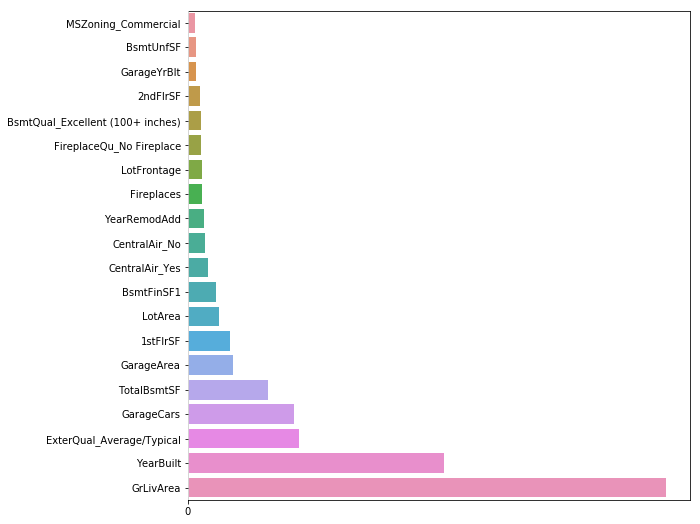

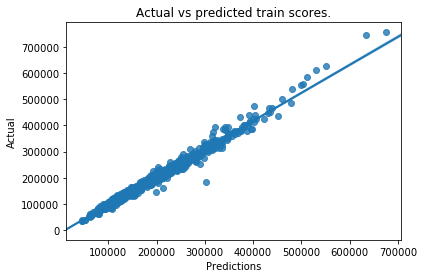

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


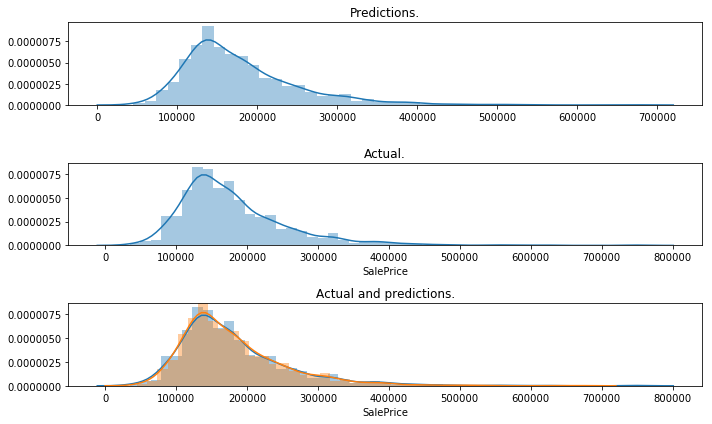

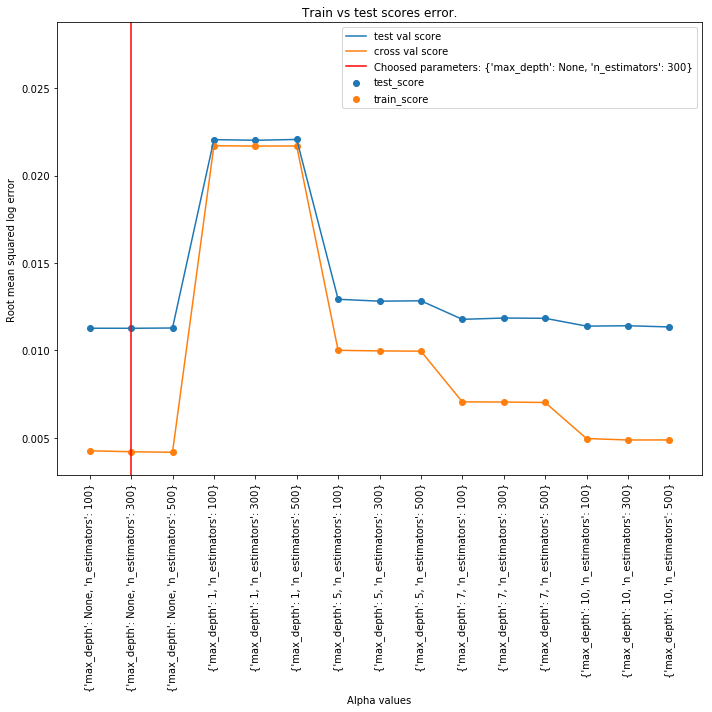

In [5]:
param_grid = {'n_estimators': [100, 300, 500], 'max_depth': [None, 1, 5, 7, 10]}
rf = RandomForestRegressor()
results = predict(TreeResults, rf, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'first_tree',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

In [157]:
dtrain = xgb.DMatrix(trainWithDummies, label = np.log1p(ytrain))
dtest = xgb.DMatrix(testWithDummies)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

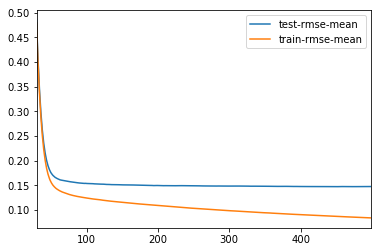

In [158]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [159]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(trainWithDummies, np.log1p(ytrain))
xgb_preds = np.expm1(model_xgb.predict(testWithDummies))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

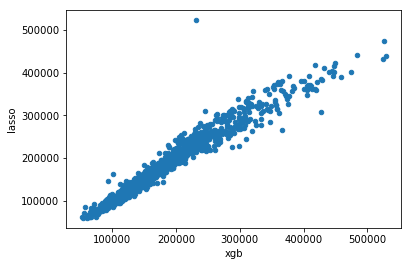

In [160]:
preds = pd.DataFrame({'xgb': xgb_preds, 'lasso':results.predictions.SalePrice})
preds.plot(kind='scatter', x='xgb', y='lasso')

In [161]:
preds.xgb.to_frame(name='SalePrice').to_csv('scores/xgboost.csv')
#0,14249

In [162]:
#0.13447
weighted_preds = 0.7*preds.lasso + 0.3*preds.xgb
weighted_preds.head()
weighted_preds.to_frame(name='SalePrice').to_csv('scores/weighted_preds.csv')

Id
1461    116893.498930
1462    147171.896039
1463    211602.968506
1464    209132.196848
1465    203108.058766
dtype: float64